In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nx = 5
nu = 1
ny = 2
seq_len = 1000
dtype = "float32"

In [3]:
sys = control.drss(states=nx, inputs=nu, outputs=ny, strictly_proper=True)
#sys.A = np.array([[0.0]])
#sys.B = np.array([[0.0]])
#sys.C = np.array([[0.0]])
#sys.D = np.array([[1.0]])
#control.tf(sys)

In [4]:
u = np.random.randn(nu, seq_len).astype(dtype)
#y = sys(u) # returns the frequency response instead...
y = control.forced_response(sys, T=None, U=u, X0=0.0)
y = y.y.transpose().astype(dtype) # to (T, C)
u = u.transpose() # to (T, C)

In [5]:
y = (y - y.mean(axis=0))/(y.std(axis=0) + 1e-6) # normalize?

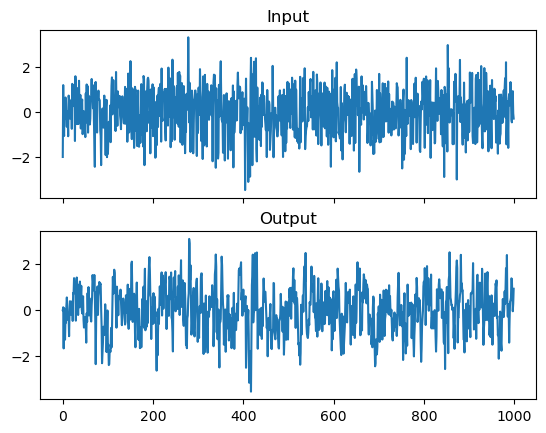

In [6]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].set_title("Input")
ax[0].plot(u[:, 0])
ax[1].set_title("Output")
ax[1].plot(y[:, 0]);

In [7]:
import torch
from torch.utils.data import DataLoader, IterableDataset

In [8]:
class LinearDynamicalDataset(IterableDataset):
    def __init__(self, nx=5, nu=1, ny=1, seq_len=500, strictly_proper=True, dtype="float32", normalize=True):
        super(LinearDynamicalDataset).__init__()
        self.nx = nx
        self.nu = nu
        self.ny = ny
        self.seq_len = seq_len
        self.strictly_proper = strictly_proper
        self.dtype = dtype
        self.normalize = normalize

    def __iter__(self):
        while True:  # infinite dataset
        #for _ in range(1000):
            sys = control.drss(states=self.nx,
                               inputs=self.nu,
                               outputs=self.ny,
                               strictly_proper=self.strictly_proper)
            u = np.random.randn(self.nu, self.seq_len).astype(self.dtype)  # C, T as python-control wants
            y = control.forced_response(sys, T=None, U=u, X0=0.0)
            u = u.transpose()  # T, C
            y = y.y.transpose().astype(self.dtype)  # T, C
            if self.normalize:
                y = (y - y.mean(axis=0))/(y.std(axis=0))

            yield torch.tensor(y), torch.tensor(u)

In [9]:
train_ds = LinearDynamicalDataset(nx=5, nu=2, ny=3, seq_len=1000)
train_dl = DataLoader(train_ds, batch_size=32)

In [10]:
batch_y, batch_u = next(iter(train_dl))

In [11]:
batch_y.shape, batch_u.shape

(torch.Size([32, 1000, 3]), torch.Size([32, 1000, 2]))